In [36]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [37]:
import pandas as pd
import numpy as np

## load dataset

In [38]:
trainset=[]
with open('/content/gdrive/My Drive/ML/yelp/train.txt') as file:   
    for line in file:
      trainset.append(line)


In [39]:
print(len(trainset))
print(trainset[0:5])

trainset=trainset

200000
['mr hoagie is an institution .\n', 'overall , its a good alternative to subway , which is down the road .\n', 'excellent food .\n', 'superb customer service .\n', 'yes this place is a little out dated and not opened on the weekend .\n']


## preprocessing

In [40]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
punct='''!()-[]{};:'"\,<>./?@#$%^&*_~'''

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:

tokens=[]
for sen in trainset:
  # print(sen)
  sen=sen.lower()
  temp=[]
  for word in sen.split():
    if word not in stop_words and word not in punct:
      temp.append(word)
  tokens.append(temp)  

In [42]:
print(tokens[1])
len(tokens)

['overall', 'good', 'alternative', 'subway', 'road']


200000

## Vocabulary

In [43]:
class Vocabulary:
  def __init__(self):
    self.word2index = {}
    self.word2count = {}
    self.index2word = {}
    self.num_words = 0
    self.num_sentences = 0
    self.longest_sentence = 0

  def add_word(self, word):
    if word not in self.word2index:
        self.word2index[word] = self.num_words
        self.word2count[word] = 1
        self.index2word[self.num_words] = word
        self.num_words += 1
    else:
        # Word exists; increase word count
        self.word2count[word] += 1
            
  def add_sentence(self, sentence):
    sentence_len = 0
    sentence_len +=1
    for word in sentence:
        sentence_len += 1
        self.add_word(word)                                 
    sentence_len +=1    
    if sentence_len > self.longest_sentence:
        # This is the longest sentence
        self.longest_sentence = sentence_len
    # Count the number of sentences
    self.num_sentences += 1
        

  def seq_to_seq(self,sentence):
    temp=[]   
    for word in sentence:
      # print(word)
      temp.append(self.to_index(word))                                           
    return temp

  def to_word(self, index):
    return self.index2word[index]

  def to_index(self, word):
    return self.word2index[word]

In [44]:
v=Vocabulary()
token_index=[]
for i in range(len(tokens)):
  v.add_sentence(tokens[i])
  token_index.append(v.seq_to_seq(tokens[i]))
token_dict=v.word2count
token_dict=sorted(token_dict.items(), key=lambda x: x[1],reverse=True)
print(token_dict)  

[("'s", 11708), ('good', 11160), ('_num_', 10503), ('food', 10369), ('great', 9905), ("n't", 9452), ('place', 8903), ('service', 7201), ('like', 4790), ('...', 4575), ('really', 4505), ('back', 4441), ('go', 4380), ('one', 4105), ('nice', 4020), ('also', 4002), ('time', 3994), ('would', 3980), ('get', 3886), ('love', 3779), ('best', 3697), ('friendly', 3526), ('always', 3480), ('staff', 3316), ('well', 3185), ("'ve", 2913), ('got', 2687), ('ordered', 2658), ('definitely', 2625), ('delicious', 2600), ('never', 2548), ('pretty', 2498), ('chicken', 2361), ('restaurant', 2262), ("'m", 2239), ('experience', 2218), ('went', 2212), ('could', 2141), ('even', 2133), ('better', 2109), ("''", 2079), ('little', 2074), ('pizza', 2074), ('amazing', 2011), ('``', 1939), ('recommend', 1924), ('bar', 1923), ('first', 1899), ('people', 1880), ('much', 1875), ('ever', 1828), ('came', 1828), ('order', 1795), ('excellent', 1773), ('try', 1732), ('cheese', 1729), ('bad', 1726), ('lunch', 1723), ('awesome', 

In [45]:
vocb_size=len(token_dict)
print(vocb_size)

34270


In [46]:
vocab_words=[]
for i in token_dict:
  vocab_words.append(i[0])
print(vocab_words[:10])

["'s", 'good', '_num_', 'food', 'great', "n't", 'place', 'service', 'like', '...']


### generate pairs

In [47]:
window_size=3
input_pairs=[]
for i in range(len(token_index)):
  for cen in range(len(token_index[i])):
    for j in range(-window_size,window_size+1):
      if((cen+j)>=0 and (cen+j)<len(token_index[i]) and j!=0):
        input_pairs.append((token_index[i][cen],token_index[i][cen+j]))

In [48]:
len(input_pairs)

2871794

In [49]:
input_word_pairs=[]
for i in input_pairs:
  input_word_pairs.append((v.to_word(i[0]),v.to_word(i[1])))
print(input_word_pairs[10:16])

[('good', 'alternative'), ('good', 'subway'), ('good', 'road'), ('alternative', 'overall'), ('alternative', 'good'), ('alternative', 'subway')]


### negative sampling


In [50]:
 def negative_sampliing(corpus_dict):
    NEG_SIZE = 1e4
    neg_word_list = []
    freq_sum=0
    for i in range(vocb_size):
      freq_sum +=corpus_dict[i][1]**0.75
    for word in corpus_dict:
      neg_word_list.extend([v.word2index[word[0]]] * int((word[1]**0.75 / freq_sum) * NEG_SIZE))
    return neg_word_list

In [51]:
neg_list=negative_sampliing(token_dict)
print(len(neg_list))
print(neg_list[10:20])

5139
[148, 148, 148, 148, 148, 148, 148, 148, 148, 148]


### model

In [52]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [53]:

class skip_gram(object):
  def __init__(self,vocb_size,latent_size):
    super().__init__()
    self.learning_rate=0.001
    self.vocab_size=vocb_size
    self.latent_dim=latent_size
    self.W1=nn.Embedding(vocb_size,latent_size,sparse=True)
    self.W2=nn.Embedding(vocb_size,latent_size,sparse=True)
    self.criterion = nn.BCEWithLogitsLoss()


  def intialise(self): 
    self.W1.weight.data.uniform_(-50,50)
    self.W2.weight.data.uniform_(-50,50)


  def forward(self,input_pairs,neg_pairs):
    center_word = [int(i[0]) for i in input_pairs]
    context_word = [int(i[1]) for i in input_pairs]

    center_embedding=self.W1(torch.LongTensor(center_word))
    context_embedding=self.W2(torch.LongTensor(context_word))
    # print("shape_neg",np.shape(np.array(neg_pairs)))
    # print("tensor=",torch.LongTensor(neg_pairs).size())

    neg_con_embedding=self.W2(torch.LongTensor(neg_pairs))
    # print("negat=",neg_con_embedding.size())

    pred=torch.mul(center_embedding,context_embedding).squeeze()
    # print("before sum pred =",pred)
    pred = torch.sum(pred, dim=1)
    # print("after sum pred =",pred)
    pred = F.logsigmoid(pred)

    # print("correct score=",pred)
    neg_score = torch.bmm(neg_con_embedding, center_embedding.unsqueeze(2)).squeeze()
    neg_score = F.logsigmoid(-1 * neg_score)
    # print("negative score =",neg_score)
    loss = -1 * (torch.sum(pred) + torch.sum(neg_score))


    # neg_loss=0
    # for i in neg_score:
    #   neg_loss += self.criterion(i, torch.zeros_like(i))

    # pos_loss = self.criterion(pred, torch.zeros_like(pred)) 
    # loss =  (torch.sum(pos_loss) + torch.sum(neg_loss))




    return loss



  def similarity(self,a,b):
    weights=self.W1
    u=weights[a]
    v=weights[b]
    sim=torch.dot(v,u)/(torch.norm(v)*torch.norm(u))
    return sim

### train

In [54]:
import torch
import torch.optim as optim

In [55]:
epochs=100
batch_size=512
neg_count=5
latent_size=50
learn_rate=0.001
batch_count=int(len(input_pairs)/batch_size)
print(batch_count)

5608


In [56]:
model=skip_gram(vocb_size,latent_size)
model.intialise()
parameter=list(model.W1.parameters()) + list(model.W2.parameters())
optimizer = optim.SGD(parameter, lr=learn_rate)

In [57]:
import time
start_time = time.time()


loss_list=[]

for epoch in range(epochs):
  loss_val=0
  for i in range(batch_count):
    batch_pairs=input_pairs[i*batch_size:(i+1)*batch_size]
    neg_pairs=np.random.choice(neg_list,size=(batch_size,neg_count)).tolist() 
    # print(np.shape(np.array(neg_pairs)))
    optimizer.zero_grad()
    loss = model.forward(batch_pairs,neg_pairs)
    loss.backward()
    optimizer.step()
    loss_val +=loss.data/batch_size
  loss_list.append(loss_val)
  print("epoch=",epoch,"loss=",loss_val.item()/batch_count)  


print("time taken for word 2 vec with negative ratio 5 is  %s seconds" % (time.time() - start_time))




epoch= 0 loss= 5784.3559201141225
epoch= 1 loss= 2242.6241084165476
epoch= 2 loss= 1420.7228958630528
epoch= 3 loss= 1042.8504814550643
epoch= 4 loss= 823.1091298145507
epoch= 5 loss= 678.788694721826
epoch= 6 loss= 577.435315620542
epoch= 7 loss= 499.1444810984308
epoch= 8 loss= 435.8597539229672
epoch= 9 loss= 386.57342189728956
epoch= 10 loss= 349.3285485021398
epoch= 11 loss= 317.92064907275324
epoch= 12 loss= 292.094552425107
epoch= 13 loss= 268.6869650499287
epoch= 14 loss= 247.78060360199714
epoch= 15 loss= 229.33730830955778
epoch= 16 loss= 212.26344062054207
epoch= 17 loss= 197.07507132667618
epoch= 18 loss= 183.0440553673324
epoch= 19 loss= 170.46158389800286
epoch= 20 loss= 159.230139978602
epoch= 21 loss= 149.21033568116977
epoch= 22 loss= 140.23401836661913
epoch= 23 loss= 132.2415522467903
epoch= 24 loss= 125.04179297432239
epoch= 25 loss= 118.66553361269615
epoch= 26 loss= 112.85787045292439
epoch= 27 loss= 107.71014621968617
epoch= 28 loss= 103.14419133380885
epoch= 29 

In [58]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2470.8936035633087 seconds ---


In [80]:
print("Average time taken for each epoch skipgram with negative sampling  ratio 15 is  %s seconds" % ((time.time() - start_time)/100))

Average time taken for each epoch skipgram with negative sampling  ratio 15 is  26.696270055770874 seconds


Text(0, 0.5, 'loss')

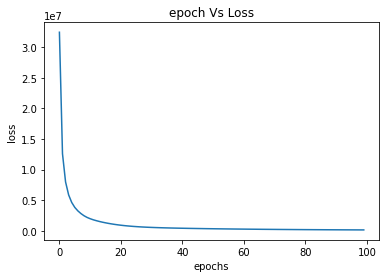

In [60]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss_list)),loss_list)
plt.title("epoch Vs Loss")
plt.xlabel("epochs")
plt.ylabel("loss")

### save model

In [61]:
torch.save(model,"/content/gdrive/MyDrive/ML/project/neg_5_epoch_100_FULL")

## sentimental analysis


In [62]:
train=[]
with open('/content/gdrive/MyDrive/ML/yelp/sentiment/1000.pos') as file:   
    for line in file:
      train.append(line)
with open('/content/gdrive/MyDrive/ML/yelp/sentiment/1000.neg') as file:   
    for line in file:
      train.append(line)


In [63]:
train_tokens=[]
ma=0
for sen in train:
  if(len(sen)>ma):
    ma=len(sen)


  # print(sen)
  sen=sen.lower()
  temp=[]
  for word in sen.split():
    if word not in stop_words and word not in punct:
      temp.append(word)
  train_tokens.append(temp)  

In [64]:
test=[]
with open('/content/gdrive/MyDrive/ML/yelp/sentiment/100.pos') as file:   
    for line in file:
      test.append(line)
with open('/content/gdrive/MyDrive/ML/yelp/sentiment/100.neg') as file:   
    for line in file:
      test.append(line)



In [65]:
test_tokens=[]
ma=0
for sen in test:
  if(len(sen)>ma):
    ma=len(sen)


  # print(sen)
  sen=sen.lower()
  temp=[]
  for word in sen.split():
    if word not in stop_words and word not in punct:
      temp.append(word)
  test_tokens.append(temp)  

In [66]:
Word2Vec=torch.load("/content/gdrive/MyDrive/ML/project/neg_5_epoch_100_FULL")

In [67]:
test_tokens[0]
v.word2index['excellent']

8

In [68]:
word_repre=Word2Vec.W1
# word_repre(torch.tensor(8)).tolist()
#

In [69]:
size=100

In [71]:
test_avg_feature=[]
for sen in test_tokens:
  # avg_vec=[0]*100
  avg_vec=np.zeros((1,latent_size),dtype='float32')
  for word in sen:
    if word in vocab_words:
      avg_vec += np.array((word_repre(torch.tensor(v.word2index[word]))).tolist())    
  test_avg_feature.append(avg_vec)  
test_avg_feature=np.array(test_avg_feature).reshape(len(test),latent_size)
test_avg_feature.shape    

(200, 50)

In [72]:
train_avg_feature=[]
count=0
for sen in train_tokens:
  # avg_vec=[0]*100
  avg_vec=np.zeros((1,latent_size),dtype='float32')
  for word in sen:
    if word in vocab_words:
      avg_vec += np.array((word_repre(torch.tensor(v.word2index[word]))).tolist())  
    else:
      count+=1    
  train_avg_feature.append(avg_vec)
train_avg_feature=np.array(train_avg_feature).reshape(len(train_avg_feature),latent_size)
train_avg_feature.shape      

(2000, 50)

In [73]:
count

65

In [74]:
train_y=[1]*1000 + [0] *1000

In [75]:
y=[1]*100 + [0] *100
len(y)

200

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
classifier= DecisionTreeClassifier(random_state=0)
classifier.fit(train_avg_feature,train_y)
y_pred= classifier.predict(test_avg_feature) 
# cross_val_score(clf, avg_feature, y, cv=10)

In [79]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

0.57